# Convert to LevSeq format


LevSeq columns:
- id (experiment_name)  
- barcode_plate (barcode_id)  
- plate (user named plate name)  
- well   
- alignment_count	 
- nucleotide_mutation	
- amino_acid_substitutions	
- alignment_probability	
- average_mutation_frequency	
- p_value	
- p_adj_value	
- nt_sequence	
- aa_sequence
- compound_smiles (smiles of the compound could be substrate or product or intermediate)
- fitness_value (fitness value for that compound for this plate)

Metadata columns:
- cif file  
- experiment_id
- experiment_name
- experiment_date
- substrate_smiles
- product_smiles
- assay_technique


Feedback on briefly looking at the curated data folder:
do you plan to add cif in there later? I only see two files in there
I see you have merged all the experiments into one big csv file. I suggest breaking each experiment (like a real world scenario) into its own csv file so like:
|--meta_file.csv
|--E-1.csv
|--E-1.cif
|--E-10.csv
|--E-10.cif
|-- etc
This will allow you to scale the data sample data. You just need to add a row to meta data when you add a file later.
3. in the data file: there are many missing columns... amino_acid_substitutions, plate for example? am i missing something? make sure the headings of each experiment data file matches the files we had (don't need X and Y)
4. in the data file: well is always 1 ! is that a typo?
5. in the meta file: I don't see a mutegenasis method. add a column accordingly. you can mark the SSM ones, blank can mean default eppcr
6. in the meta file: you have see the "literature" as the assay method
I don't see literature in the assay list you guys had provided early on
do you want to provide a bit more variety to this column for the paper?

In [58]:
# Get the heme we want as well

In [26]:
import pandas as pd
df = pd.read_csv('output/protein-evolution-database_V5_proteins_reactions_clean.csv')
df['index'] = [i for i in range(0, len(df))]
df.columns


Index(['culture_collection_entry', 'enzyme_name_from_paper',
       'Uniprot_ID(if applicable)', 'comment', 'reaction_smiles',
       'parent_DNA_sequence', 'parent_aminoacid_sequence',
       'aminoacid_mutations_from_parent', 'variant_DNA_sequence',
       'mutations_from_parent', 'cofactor', 'additive (if applicable)',
       'additive_CAS', 'enzyme_form', 'substrate_concentration',
       'activity_for_reaction_% (if applicable)', 'TTN (if applicable)',
       'selectivity(ee%),diastereo or chemo should be a separate smiles entry',
       'alternative_product_SMILES', 'failed_substrates (if available)',
       'date published ', 'first author', 'paper title', 'doi', 'SUBMITTED BY',
       'raw data name', 'cannonical_reactions', 'named_reactions', 'errors',
       'parent_aa', 'variant_aa', 'warnings', 'id', 'index'],
      dtype='object')

# Report data on these 

In [27]:
len(df)

1325

In [28]:
len(set(df['paper title'].values))

36

In [29]:
len(set(df['reaction_smiles'].values))

666

In [63]:
len(set(df['aa_sequence'].values))

362

# Copy across the CIF files that match to these parents

In [30]:
# Probably should take the best chai... read in the 
df['cif_path'] = [f'DEDB_Chai_Man/{id}/chai/{id}_0.cif' for id in df['id'].values]
df['cif'] = [f'{id}_0.cif' for id in df['id'].values]

cif_to_id = dict(zip(df['cif_path'], df['id']))
# Copy each one to the new folder
import os



In [62]:
1143 + 1325

2468

# First assign experiment ids based on the parent and the reaction


In [31]:
experiment_to_id = {}
df = df.sort_values(by='date published ')
paper_to_id = {p:i for i, p in enumerate(set(df['paper title'].values))}
experiment_labels = []
i = 1
for parent_aa, cannonical_reactions in df[['parent_aa', 'cannonical_reactions']].values:
    label = f'{parent_aa}_{cannonical_reactions}'
    if experiment_to_id.get(label):
        experiment_labels.append(experiment_to_id.get(label))
    else:
        experiment_to_id[label] = f'E-{i}'
        experiment_labels.append(f'E-{i}')
        i += 1

df['experiment_id'] = experiment_labels
df['barcode_plate'] = 1
df['plate'] = 1
df['well'] = 1
df['alignment_count'] = 100
df['average_mutation_frequency'] = 1
df['alignment_probability'] = 1
df['p_value'] = 0.01
df['p_adj_value'] = 0.01
df['nt_sequence'] = [v if '?' not in v else a for v, a in df[['variant_DNA_sequence', 'parent_DNA_sequence']].values]
df['aa_sequence'] = df['variant_aa'].values


# Clean DNA mutations

In [32]:
nucleotide_mutations = []
for nt_to_change, aa_to_change in df[['mutations_from_parent', 'aminoacid_mutations_from_parent']].values:
    if nt_to_change == '?':
        if aa_to_change == '?':
            nucleotide_mutations.append('#PARENT#')
        else:
            nucleotide_mutations.append('#N.A.#')
    elif not isinstance(nt_to_change, str):
        print(nt_to_change)
        nucleotide_mutations.append('#N.A.#')
    else:
        # check what separator was used
        sep = '_'
        if '_' in nt_to_change:
            sep = '_'
        elif ',' in nt_to_change:
            sep = ','
        elif '-' in nt_to_change:
            sep = '-'
        nt_to_change = nt_to_change.split(sep)
        clean_nt = []
        for nt in nt_to_change:
            if 'FAD' not in nt:
                nt = nt.split('+')[0] # Remove any random domains... 
                nt = nt.replace(' ', '')
                nt = nt.upper()
                clean_nt.append(nt)
        if len(clean_nt) == 0:
            nucleotide_mutations.append('#N.A.#')
            print(nt_to_change)
        nucleotide_mutations.append('_'.join(clean_nt))
df['nucleotide_mutation'] = nucleotide_mutations

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


# Clean AA substitutions

In [33]:

# Clean the AA substitutions
amino_acid_substitutions = []
for aa_to_change in df['aminoacid_mutations_from_parent'].values:
    if aa_to_change == '?':
        amino_acid_substitutions.append('#PARENT#')
    elif not isinstance(aa_to_change, str):
        print(aa_to_change)
        amino_acid_substitutions.append('#N.A.#')
    else:
        # check what separator was used
        if '_' in aa_to_change:
            sep = '_'
        elif ',' in aa_to_change:
            sep = ','
        elif '-' in aa_to_change:
            sep = '-'
        aa_to_change = aa_to_change.split(sep)
        clean_aa = []
        for aa in aa_to_change:
            if 'FAD' not in aa:
                aa = aa.split('+')[0] # Remove any random domains... 
                aa = aa.replace(' ', '')
                aa = aa.upper()
                clean_aa.append(aa)
        if len(clean_aa) == 0:
            amino_acid_substitutions.append('#N.A.#')
            print(aa_to_change)
        amino_acid_substitutions.append('_'.join(clean_aa))
        
df['amino_acid_substitutions'] = amino_acid_substitutions
df[df['amino_acid_substitutions'].isna()]

,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,mutations_from_parent,...,well,alignment_count,average_mutation_frequency,alignment_probability,p_value,p_adj_value,nt_sequence,aa_sequence,nucleotide_mutation,amino_acid_substitutions


# Add in fitness and the smiles string

In [34]:
# Here we just do it for the product
df['smiles_string'] = [s.split('>>')[-1] for s in df['reaction_smiles'].values]

# Save as a newly formatted DF

In [35]:
df['paper title'].value_counts() # Maybe make the experiment ID and the paper title an ID?

Enzymatic Lactone-Carbene C−H Insertion to Build Contiguous Chiral Centers                                                            200
Biocatalytic Synthesis of α‑Amino Esters via Nitrene C−H Insertion                                                                     97
Enantio- and Diastereoenriched Enzymatic Synthesis of 1,2,3- Polysubstituted Cyclopropanes from (Z/E)‑Trisubstituted Enol Acetates     84
Enzymatic Nitrogen Insertion into Unactivated C–H Bonds                                                                                81
Biocatalytic, Intermolecular C−H Bond Functionalization for the Synthesis of Enantioenriched Amides                                    56
Enzymatic Primary Amination of Benzylic and Allylic C(sp3)–H Bonds                                                                     54
Enzymatic Assembly of Diverse Lactone Structures: An Intramolecular C−H Functionalization Strategy                                     50
An enzymatic platform for the asym

# Keep experiemnts which have more than 2 counts 


In [36]:
df['experiment_id'].value_counts()

E-650    53
E-201    18
E-203    18
E-144    18
E-200    18
         ..
E-267     1
E-268     1
E-270     1
E-276     1
E-672     1
Name: experiment_id, Length: 672, dtype: int64

In [37]:
experiments = set(df['experiment_id'].value_counts()[df['experiment_id'].value_counts().values > 2].index)
experiments

{'E-109',
 'E-132',
 'E-137',
 'E-144',
 'E-145',
 'E-15',
 'E-154',
 'E-155',
 'E-156',
 'E-169',
 'E-171',
 'E-172',
 'E-173',
 'E-174',
 'E-184',
 'E-185',
 'E-186',
 'E-190',
 'E-191',
 'E-192',
 'E-194',
 'E-198',
 'E-200',
 'E-201',
 'E-203',
 'E-206',
 'E-207',
 'E-209',
 'E-212',
 'E-214',
 'E-222',
 'E-24',
 'E-255',
 'E-256',
 'E-263',
 'E-269',
 'E-271',
 'E-273',
 'E-274',
 'E-275',
 'E-278',
 'E-283',
 'E-284',
 'E-285',
 'E-290',
 'E-316',
 'E-322',
 'E-330',
 'E-38',
 'E-387',
 'E-390',
 'E-427',
 'E-440',
 'E-491',
 'E-499',
 'E-500',
 'E-524',
 'E-53',
 'E-531',
 'E-532',
 'E-542',
 'E-55',
 'E-566',
 'E-569',
 'E-57',
 'E-570',
 'E-576',
 'E-577',
 'E-578',
 'E-589',
 'E-595',
 'E-605',
 'E-650',
 'E-652',
 'E-67',
 'E-9',
 'E-93',
 'E-94',
 'E-95',
 'E-97'}

(array([28., 12., 25.,  6.,  2.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 3. ,  5.5,  8. , 10.5, 13. , 15.5, 18. , 20.5, 23. , 25.5, 28. ,
        30.5, 33. , 35.5, 38. , 40.5, 43. , 45.5, 48. , 50.5, 53. ]),
 <BarContainer object of 20 artists>)

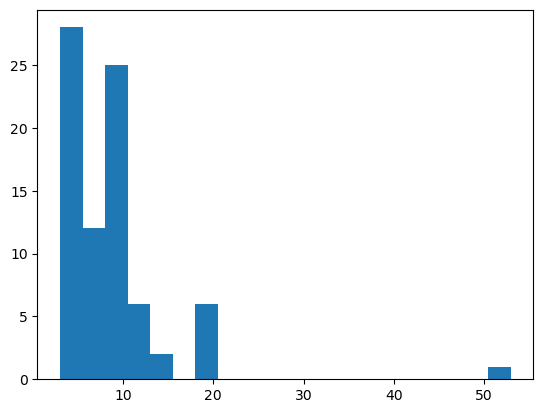

In [38]:
import matplotlib.pyplot as plt

plt.hist(df['experiment_id'].value_counts()[df['experiment_id'].value_counts().values > 2], bins=20)

In [39]:
# Change the plate to be the paper
levseq_df = df.copy() #[df['experiment_id'].isin(experiments)]
levseq_df['plate'] = levseq_df['paper title'].values
fitness = []
fitness_type = []
for ttn, activity in levseq_df[['TTN (if applicable)', 'activity_for_reaction_% (if applicable)']].values:
    if ttn == 'trace':
        ttn = 1.0
    if activity == 'trace':
        activity = 0.001 
    try:
        ttn = float(ttn)
    except:
        try:
            activity = float(activity)
        except:
            fitness.append(None)
            fitness_type.append(None)
            print(ttn, activity)
            continue
    if ttn != '?':
        if not isinstance(ttn, float) and not isinstance(ttn, int):
            print(ttn)
            fitness.append(0.0)
        else:
            fitness.append(float(ttn))
            fitness_type.append('TTN')
    elif activity != '?':
        if not isinstance(activity, float) and not isinstance(ttn, int):
            print(ttn)
            fitness.append(0.0)
        else:
            fitness.append(float(activity))
        fitness_type.append('Activity')
    else:
        fitness.append(None)
        print(ttn)
levseq_df['fitness_value'] = fitness
levseq_df['fitness_type'] = fitness_type
levseq_df['fitness_value']

? ?
? ?
? ?
? ?
? ?
? ?
? ?
? ?
? ?
? ?
? ?
? ?
? ?
? ?


1289    510.000
1294     47.000
1295    660.000
1296    930.000
1297    520.000
         ...   
678      59.000
677      67.000
676      57.000
731       0.001
683      85.000
Name: fitness_value, Length: 1325, dtype: float64

In [40]:
levseq_df = levseq_df.sort_values(by='index')
for paper_title, grp in levseq_df.groupby('paper title'):
    exp_id = paper_to_id.get(paper_title)
    
    chars = ['A', 'B', 'C', 'D', 'E', 'F', 'D', 'G', 'H']
    experiment_df = pd.DataFrame()
    rows = []
    barcode_plate = 1
    columns = ['id', 
                'barcode_plate', 
                'plate',
                'well', 
                'amino_acid_substitutions',
                'alignment_count', 
                'alignment_probability',
                'average_mutation_frequency', 
                'p_value', 
                'p_adj_value', 
                'nt_sequence', 
                'aa_sequence',
                'smiles_string',
                'fitness_value'
                ]
    char_i = 0
    row_idx = 1
    experiment_idx = 0
    for row in grp[columns].values:
        if experiment_idx == 0:
            # Make this one have the parent in it
            row[4] = '#PARENT#'
        row_label = chars[char_i]
        # Here we can make the plate index
        row[1] = barcode_plate
        row[3] = f'{row_label}{row_idx}'
        rows.append(row)
        if row_idx == 12:
            row_idx = 0
            char_i += 1
            if row_label == 'H':
                char_i = 0
                barcode_plate += 1
                # For now just reset
                experiment_idx = 0
        row_idx += 1
        experiment_idx += 1
    experiment_df = pd.DataFrame(rows, columns=columns)
    experiment_df = experiment_df.replace(0, 0.00001)
    experiment_df.to_csv(f'DEDB_V5/experiments/exp_{exp_id}.csv', index=False)

# Now also make a metadata df to go with each one

Metadata columns:
- cif file  
- experiment_id
- experiment_name
- experiment_date
- substrate_smiles
- product_smiles
- assay_technique

```
Index(['Unnamed: 0', 'culture_collection_entry', 'enzyme_name_from_paper',
       'Uniprot_ID(if applicable)', 'comment', 'reaction_smiles',
       'parent_DNA_sequence', 'parent_aminoacid_sequence',
       'aminoacid_mutations_from_parent', 'variant_DNA_sequence',
       'mutations_from_parent', 'cofactor', 'additive (if applicable)',
       'additive_CAS', 'enzyme_form', 'substrate_concentration',
       'activity_for_reaction_% (if applicable)', 'TTN (if applicable)',
       'selectivity(ee%),diastereo or chemo should be a separate smiles entry',
       'alternative_product_SMILES', 'failed_substrates (if available)',
       'date published ', 'first author', 'paper title', 'doi', 'SUBMITTED BY',
       'raw data name', 'cannonical_reactions', 'named_reactions', 'errors',
       'parent_aa', 'variant_aa', 'warnings', 'id'],
      dtype='object')

```

In [41]:
doi_to_date = {'DOI: 10.1126/science.aah6219': '25.11.2016',
 'DOI: 10.1126/science.adi5554': '25.01.2024',
 'doi.org/10.1002/anie.202002861': '24.03.2020',
 'doi.org/10.1002/anie.202106938': '15.07.2021',
 'doi.org/10.1002/anie.202110873': '17.09.2021',
 'doi.org/10.1002/anie.202303879': '01.06.2023',
 'doi.org/10.1002/cbic.201900497': '12.09.2019',
 'doi.org/10.1021/acscatal.0c01349': '20.04.2020',
 'doi.org/10.1021/acscatal.0c01888': '04.06.2020',
 'doi.org/10.1021/acscatal.3c05370': '16.12.2023',
 'doi.org/10.1021/acscatal.9b02089': '20.08.2019',
 'doi.org/10.1021/acscentsci.3c00516': '14.12.2023',
 'doi.org/10.1021/jacs.0c01313': '29.03.2020',
 'doi.org/10.1021/jacs.0c03428': '25.05.2020',
 'doi.org/10.1021/jacs.1c11340': '23.12.2021',
 'doi.org/10.1021/jacs.2c00251': '08.03.2022',
 'doi.org/10.1021/jacs.2c02723': '13.05.2022',
 'doi.org/10.1021/jacs.2c08285': '04.10.2022',
 'doi.org/10.1021/jacs.3c04870': '11.07.2023',
 'doi.org/10.1021/jacs.3c11722': '02.01.2024',
 'doi.org/10.1021/jacs.4c09989': '27.09.2024',
 'doi.org/10.1021/jacs.9b04344': '07.06.2019',
 'doi.org/10.1021/jacs.9b09864': '20.11.2019',
 'doi.org/10.1038/s41557-019-0343-5': '14.10.2019',
 'doi.org/10.1038/s41589-024-01619-z': '14.05.2024',
 'doi.org/10.1038/s41929-022-00908-x': '19.01.2023',
 'doi.org/10.1038/s41929-024-01149-w': '03.05.2024',
 'doi.org/10.1038/s44160-023-00431-2': '02.11.2023',
 'doi/10.1021/jacs.4c04190': '03.07.2024',
 'doi: 10.1055/s-0037-1611662': '14.01.2019',
 'doi:10.1038/nature24996': '29.11.2017',
 'https://doi.org/10.1002/anie.202208936': '19.12.2022',
 'https://doi.org/10.1021/jacs.3c08053': '06.09.2023',
 'https://doi.org/10.1021/jacs.9b02931': '09.05.2019',
 'https://doi.org/10.1021/jacs.9b11608': '02.12.2019',
 'https://doi.org/10.1038/s41557-021-00794-z': '18.10.2021'}

In [42]:
cofactor_df = pd.read_csv('../data/paper_cofactor_categories_chemistry_20250516210647.csv')
cofactor_df = cofactor_df.dropna()
paper_to_cofactor = dict(zip(cofactor_df.paper_title, cofactor_df.cofactor_smiles))

In [50]:
metadata_rows = []
for name, experiment in levseq_df.groupby('paper title'):
    experiment_id = f'exp_{paper_to_id.get(name)}'
    #if name != 'An Enzymatic Platform for Primary Amination of 1-Aryl-2-alkyl Alkynes':
    # this is what makes each a row in the df (each should have the same reaction/products and substrates)
    all_products = []
    all_substrates = []
    main_reaction = experiment['cannonical_reactions'].values[0]
    
    products = '.'.join(list(set(main_reaction.split('>>')[1].split('.'))))
    substrates = '.'.join(list(set(main_reaction.split('>>')[0].split('.'))))
    if paper_to_cofactor.get(name):
        substrates += '.' +  paper_to_cofactor.get(name)
    paper = experiment['paper title'].values[0]
    date = '11/08/2025' #doi_to_date.get(experiment['doi'].values[0])
    cif = experiment['cif'].values[0]
    seq = experiment['aa_sequence'].values[0]
    seq = seq.replace('*', '')
    metadata_rows.append([experiment_id, paper, date, substrates, products, 'literature', seq, cif])

metadata_df = pd.DataFrame(metadata_rows, columns=['experiment_id', 'experiment_name', 'experiment_date', 'substrate_smiles', 'product_smiles', 'assay_technique', 'parent_amino_acid', 'cif_filename'])
metadata_df

,experiment_id,experiment_name,experiment_date,substrate_smiles,product_smiles,assay_technique,parent_amino_acid,cif_filename
0,exp_21,An Enzymatic Platform for Primary Amination of...,11/08/2025,O=S(=O)(O)C(F)(F)F.CCC#Cc1ccccc1.CC(C)(C)C(=O)...,C[C@@H](N)C#Cc1ccccc1,literature,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,DEDB363_0.cif
1,exp_13,An enzymatic platform for the asymmetric amina...,11/08/2025,CN(CCc1ccccc1)S(=O)(=O)N=[N+]=[N-],CN1C[C@H](c2ccccc2)NS1(=O)=O,literature,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,DEDB391_0.cif
2,exp_33,Asymmetric Alkylation of Ketones Catalyzed by ...,11/08/2025,CCC(=O)c1ccccc1.N[C@@H](CO)C(=O)O.CC1=NC=C(C(=...,CC(C[C@H](N)C(=O)O)C(=O)c1ccccc1,literature,MKGYFGPYGGQYVPEILMGALEELEAAYEGIMKDESFWKEFNDLLR...,DEDB1031_0.cif
3,exp_4,Biocatalytic Carbene Transfer Using Diazirines,11/08/2025,c1ccc(C2N=N2)cc1.C=CC(=O)OCc1ccccc1.CC1=C(C2=C...,O=C(OCc1ccccc1)[C@H]1C[C@H]1c1ccccc1,literature,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACD...,DEDB809_0.cif
4,exp_27,Biocatalytic Construction of Chiral Pyrrolidin...,11/08/2025,[N-]=[N+]=NCCCCc1ccccc1,c1ccc([C@H]2CCCN2)cc1,literature,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,DEDB772_0.cif
5,exp_5,Biocatalytic One-Carbon Ring Expansion of Azir...,11/08/2025,O=C(OCc1ccccc1)N1CC1.CCOC(=O)C=[N+]=[N-].CC1=C...,CCOC(=O)[C@@H]1CCN1C(=O)OCc1ccccc1,literature,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,DEDB823_0.cif
6,exp_0,Biocatalytic Synthesis of α‑Amino Esters via N...,11/08/2025,CCOC(=O)Cc1ccc(F)cc1.CC(C)(C)C(=O)O[NH3+].O=S(...,CCOC(=O)[C@@H](N)c1ccc(F)cc1,literature,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACD...,DEDB675_0.cif
7,exp_29,"Biocatalytic, Intermolecular C−H Bond Function...",11/08/2025,CCc1ccc(OC)cc1.CC(C)(C)C(=O)ONC(=O)CCc1ccccc1,COc1ccc([C@H](C)NC(=O)CCc2ccccc2)cc1,literature,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,DEDB1161_0.cif
8,exp_31,"Biocatalytic, Stereoconvergent Alkylation of (...",11/08/2025,CC/C=C(/O[Si](C)(C)C)c1ccccc1.CC/C=C(\O[Si](C)...,CC[C@@H](CC#N)C(=O)c1ccccc1,literature,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,DEDB894_0.cif
9,exp_15,"Biocatalytic, enantioenriched primary aminatio...",11/08/2025,CCC(C)c1ccccc1.O=S(=O)(O)C(F)(F)F.CC(C)(C)C(=O)ON,CC[C@](C)(N)c1ccccc1,literature,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,DEDB841_0.cif


In [51]:
metadata_df.to_csv('DEDB_V5/LevSeq-metadata_formatted_protein-evolution-database_V5.csv', index=False)

In [52]:
chosen_structures = set(metadata_df['cif_filename'].values) #.value_counts()

In [53]:
# just want to make sure the parent is in there
cifs_to_do = []
for cif in set(df['cif_path'].values):
    if cif.split('/')[-1] in chosen_structures:
        if os.path.exists(cif):
            try:
                os.system(f'cp {cif} DEDB_V5/structures/')
            except:
                print(cif)
        else:
            cifs_to_do.append(cif)
            print(cif)

DEDB_Chai_Man/DEDB1239/chai/DEDB1239_0.cif
DEDB_Chai_Man/DEDB363/chai/DEDB363_0.cif
DEDB_Chai_Man/DEDB841/chai/DEDB841_0.cif
DEDB_Chai_Man/DEDB1217/chai/DEDB1217_0.cif
DEDB_Chai_Man/DEDB117/chai/DEDB117_0.cif
DEDB_Chai_Man/DEDB510/chai/DEDB510_0.cif
DEDB_Chai_Man/DEDB894/chai/DEDB894_0.cif
DEDB_Chai_Man/DEDB934/chai/DEDB934_0.cif
DEDB_Chai_Man/DEDB863/chai/DEDB863_0.cif
DEDB_Chai_Man/DEDB675/chai/DEDB675_0.cif
DEDB_Chai_Man/DEDB478/chai/DEDB478_0.cif
DEDB_Chai_Man/DEDB594/chai/DEDB594_0.cif


In [54]:
# Combine the two metadata's into 
# Save these to a csv file so that we can generate them
structures_to_do = df[df['cif_path'].isin(cifs_to_do)]
structures_to_do.to_csv('output/structures_to_do.csv', index=False)

In [59]:
structures_to_do['id']

478      DEDB478
117      DEDB117
934      DEDB934
363      DEDB363
594      DEDB594
1201    DEDB1217
510      DEDB510
1223    DEDB1239
894      DEDB894
841      DEDB841
863      DEDB863
675      DEDB675
Name: id, dtype: object

In [60]:
structures_to_do['aa_sequence']

478     MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
117     MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
934     MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
363     MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
594     TIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAPG...
1201    MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACD...
510     MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
1223    MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...
894     MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
841     MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
863     MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACD...
675     MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACD...
Name: aa_sequence, dtype: object

In [61]:
structures_to_do

,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,mutations_from_parent,...,alignment_count,average_mutation_frequency,alignment_probability,p_value,p_adj_value,nt_sequence,aa_sequence,nucleotide_mutation,amino_acid_substitutions,smiles_string
478,4821,P411-CH-C8,?,?,[N-]=[N+]=CC(F)(F)F.C1(N2CCCC2)=CC=CC=C1>>FC(C...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,100,1,1,0.01,0.01,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,#N.A.#,T327V,FC(C[C@@H](CCC3)N3C4=CC=CC=C4)(F)F
117,4866,P411-C10,?,express at 22 °C,CC1=CC=C(N(C)C)C=C1.O=C2OCCC2=[N+]=[N-]>>CC3=C...,ACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTAAAA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,N70E_A74G_V78L_A82L_F87A_M118S_P142S_F162L_T17...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,100,1,1,0.01,0.01,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,#N.A.#,N70E_A74G_V78L_A82L_F87A_M118S_P142S_F162L_T17...,CC3=CC=C(N(C)C[C@H]4CCOC4=O)C=C3
934,?,P411-B2,?,?,[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.C12...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,100,1,1,0.01,0.01,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,#PARENT#,#PARENT#,N[C@@H]3CCCC4=CC=CC=C43
363,5003,P411-PA-G0,?,NaN,CCC#CC1=CC=CC=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,V78M_A82L_F87A_P142S_T175I_A184V_S226R_H236Q_E...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,100,1,1,0.01,0.01,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,#N.A.#,V78M_A82L_F87A_P142S_T175I_A184V_S226R_H236Q_E...,C[C@@H](N)C#CC2=CC=CC=C2
594,5102,uPA0,?,?,CC1CCCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([...,ACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTAAAA...,TIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAPG...,?,ACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTAAAA...,?,...,100,1,1,0.01,0.01,ACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTAAAA...,TIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAPG...,#PARENT#,#PARENT#,C[C@@H]2C[C@H](N)CCC2
1201,?,ApePgb-LQ,?,?,O=C(OCC1=CC=CC=C1)C=C.[N-]=[N+]=CC(F)(F)F>>O=C...,ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACD...,W59L_Y60Q,ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...,?,...,100,1,1,0.01,0.01,ATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGA...,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACD...,#N.A.#,W59L_Y60Q,O=C(OCC2=CC=CC=C2)[C@@H]3C[C@@H]3C(F)(F)F
510,5182,P411-INC-5182,?,?,CC/C=C(OC(C)=O)/C1=CC=CC=C1.O=C(C)O/C(C2=CC=CC...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,100,1,1,0.01,0.01,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,#PARENT#,#PARENT#,CC(O[C@]3(C4=CC=CC=C4)[C@H](C#N)[C@@H]3CC)=O
1223,5209,ParPgb-HYA-5209,?,?,C=CC1=CC=C(OC)C=C1.NO.[H]Cl>>CC(N)C2=CC=C(OC)C=C2,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...,?,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,?,...,100,1,1,0.01,0.01,ATGGCGGTTCCCGGCTACGATTTTGGCAAAGTCCCGGATGCCCCAA...,MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...,#PARENT#,#PARENT#,CC(N)C2=CC=C(OC)C=C2
894,5183,IC-G1,NaN,NaN,CC/C=C(O[Si](C)(C)C)\C1=CC=CC=C1.CC/C=C(O[Si](...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,Y263W_ I327P,?,NaN,...,100,1,1,0.01,0.01,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,#N.A.#,Y26